In [29]:
import fireworks
from fireworks.ic import ic_two_body as ic_two_body

from fireworks.nbodylib import dynamics as dyn
from fireworks.nbodylib import integrators as intg

import matplotlib.pyplot as plt
import numpy as np

In [30]:
mass1 = 1.0
mass2 = 1.0
rp = 2.0
e = 0.0

particles = ic_two_body(mass1, mass2, rp, e)

Estimate binary period.

From Kepler's law:

$$
T^2 = \frac{4 \pi^2}{G(M+m)}  a^3
$$

where $a$ is the semi-major axis, which is given from initial condition $rp = r_{min}$:

$$
a=\frac{r_{min}}{(1-e)}
$$

In [31]:
a = rp / (1 - e)  # Semi-major axis
period = 2 * np.pi * np.sqrt(a**3 / (mass1 + mass2))


Develop an interactive method to evolve the binary system from 0 to 10x Tperiod

In [32]:
def simulate(integrator,particles,tstep=0.01,total_time = 10*period):

   acc_list       = np.array([])
   pos_list       = np.array([])
   vel_list       = np.array([])
   kinetic_list   = np.array([])
   potential_list = np.array([])
   energy_list    = np.array([])
   
   
   for _ in range(int(total_time/tstep)):

      particles, tstep, acc, jerk, _ = integrator(particles=particles, 
                                               tstep=tstep, 
                                               acceleration_estimator=dyn.acceleration_direct_vectorized,
                                               softening=0.1,
                                               )
      
      acc_list = np.append(acc_list, acc)
      pos_list = np.append(pos_list, particles.pos)
      vel_list = np.append(vel_list, particles.vel)

      kinetic_list   = np.append(kinetic_list, particles.Ekin())
      potential_list = np.append(potential_list, particles.Epot(softening=0.1))
      energy_list    = np.append(energy_list, particles.Etot(softening=0.1))


   acc_list = acc_list.reshape(int(total_time/tstep), 2, 3)
   pos_list = pos_list.reshape(int(total_time/tstep), 2, 3)
   vel_list = vel_list.reshape(int(total_time/tstep), 2, 3)

   return acc_list, pos_list, vel_list, kinetic_list, potential_list, energy_list
      


In [33]:
simulation_data = {}

for integrator in [intg.integrator_euler, intg.integrator_leapfrog]:
   acc_list, pos_list, vel_list, kinetic_list, potential_list, energy_list = simulate(integrator,particles,tstep=.1)

   simulation_data[integrator.__name__] = {"acc_list": acc_list, "pos_list": pos_list, "vel_list": vel_list, "energy_list": energy_list}
   

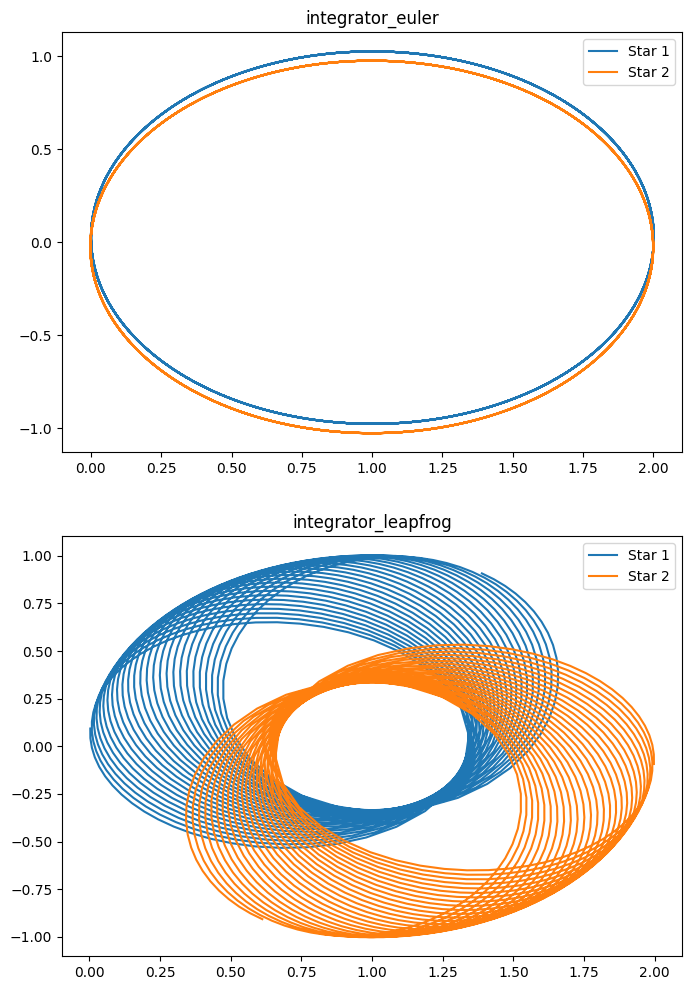

In [34]:
# Get the list of integrators from the simulation_data dictionary
integrators = list(simulation_data.keys())

# Create a grid plot with subplots for each integrator
fig, axs = plt.subplots(len(integrators), 1, figsize=(8, 6 * len(integrators)))

# Iterate over each integrator and plot pos_list
for i, integrator in enumerate(integrators):
    pos_list = simulation_data[integrator]["pos_list"]
    axs[i].plot(pos_list[:, 0, 0], pos_list[:, 0, 1], label="Star 1")
    axs[i].plot(pos_list[:, 1, 0], pos_list[:, 1, 1], label="Star 2")
    axs[i].set_title(integrator)
    axs[i].legend()



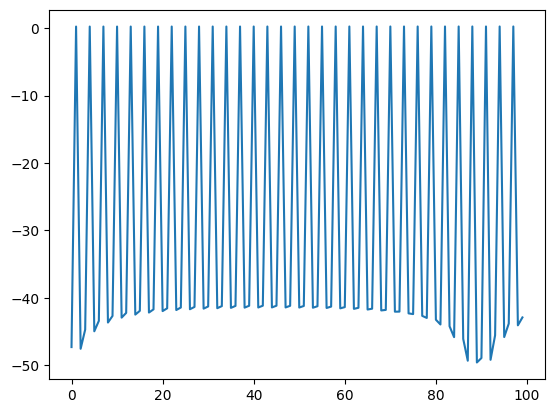

In [35]:
plt.plot(simulation_data["integrator_euler"]["energy_list"][:100])

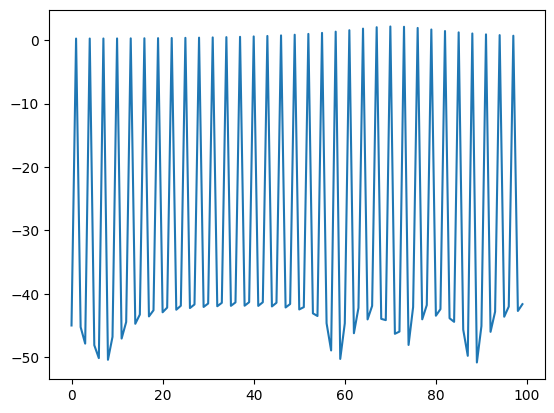

In [36]:
plt.plot(simulation_data["integrator_leapfrog"]["energy_list"][:100])

In [37]:
acc, jerk, pot = dyn.acceleration_direct_vectorized(particles, softening=0.1)

In [38]:
jerk

array([[ 0.13933978, -0.00935742, -0.        ],
       [-0.13933978,  0.00935742, -0.        ]])

In [39]:
# Does Hermite work?
tstep=0.01
total_time = 10*period

pos_h       = np.array([])
acc_h       = np.array([])
vel_h       = np.array([])
kinetic_h   = np.array([])
potential_h = np.array([])
energy_h    = np.array([])


for _ in range(int(total_time/tstep)):

    particles, tstep, acc, jerk, _ = intg.integrator_hermite(
                                            particles=particles, 
                                            tstep=tstep, 
                                            acceleration_estimator=dyn.acceleration_direct_vectorized,
                                            softening=0.1
                                            
                                            )
    
    acc_h = np.append(acc_h, acc)
    pos_h = np.append(pos_h, particles.pos)
    vel_h = np.append(vel_h, particles.vel)

    kinetic_h   = np.append(kinetic_h, particles.Ekin())
    potential_h = np.append(potential_h, particles.Epot(softening=0.1))
    energy_h    = np.append(energy_h, particles.Etot(softening=0.1))


acc_h = acc_h.reshape(int(total_time/tstep), 2, 3)
pos_h = pos_h.reshape(int(total_time/tstep), 2, 3)
vel_h = vel_h.reshape(int(total_time/tstep), 2, 3)
   


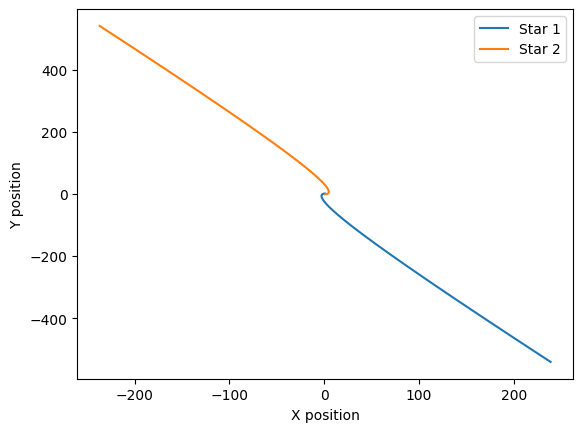

In [40]:

# Get the x and y coordinates of the first star
x_star1 = pos_h[:, 0, 0]
y_star1 = pos_h[:, 0, 1]

# Get the x and y coordinates of the second star
x_star2 = pos_h[:, 1, 0]
y_star2 = pos_h[:, 1, 1]

# Plot the positions of the stars
plt.plot(x_star1, y_star1, label="Star 1")
plt.plot(x_star2, y_star2, label="Star 2")

# Add labels and legend
plt.xlabel("X position")
plt.ylabel("Y position")
plt.legend()

# Show the plot
plt.show()
